In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scanpy as sc
import sklearn
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl
import scipy
import random
import scgpt as scg
from pathlib import Path

import sklearn


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# make GPU visible
os.environ["CUDA_VISIBLE_DEVICES"]="3"
torch.cuda.is_available()

# read data

In [2]:
h5ad_path = "/data/rna_rep_learning/hlca_sikkema2023/397410c1-bdc6-412d-888e-60cc401dd923.h5ad"
hlca_adata = sc.read_h5ad(h5ad_path)

In [4]:
hlca_adata

AnnData object with n_obs × n_vars = 2282447 × 56239
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 

In [6]:
hlca_adata.X.min()

0.0

In [17]:
hlca_adata.X.max()

8.863389

In [8]:
hlca_adata.raw.X.min()

0.0

In [9]:
hlca_adata.raw.X.max()

38487.0

In [10]:
hlca_adata.obsm['X_scanvi_emb'].shape

(2282447, 30)

## embed cells using scGPT

In [6]:
model_dir = Path("/data/rna_rep_learning/scGPT/scGPT_human")

In [7]:
# move raw counts to X for highly variable gene selection
hlca_adata.layers['counts'] = hlca_adata.raw.X.copy()
hlca_adata.layers['lognorm'] = hlca_adata.X.copy()
del hlca_adata.raw

In [8]:
# select highly variable genes
sc.pp.highly_variable_genes(hlca_adata, flavor='seurat')
hlca_adata_hvg = hlca_adata[:, hlca_adata.var['highly_variable']].copy()
np.sum(hlca_adata_hvg.X.sum(axis=1)==0) #want this to be 0

0

In [9]:
hlca_adata_hvg = scg.tasks.embed_data(
    hlca_adata_hvg,
    model_dir,
    gene_col="feature_name",
    batch_size=64,
    return_new_adata=False,
)

scGPT - INFO - match 3494/3779 genes in vocabulary of size 60697.


Embedding cells: 100%|█████████████████████████████████████████████████████████████████████████████| 35664/35664 [19:31<00:00, 30.44it/s]
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


In [10]:
#save this new adata
hlca_adata_hvg.write("/data/rna_rep_learning/hlca_sikkema2023/hlca_HVGonly_w_scGPT_embeds.h5ad")

In [2]:
hlca_adata_hvg = sc.read_h5ad("/data/rna_rep_learning/hlca_sikkema2023/hlca_HVGonly_w_scGPT_embeds.h5ad")

### Check that these scGPT embeddings look reasonable

In [12]:
sc.pp.neighbors(hlca_adata_hvg, use_rep="X_scGPT")

In [5]:
sc.tl.umap(hlca_adata_hvg)

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


In [9]:
#save this new adata
hlca_adata_hvg.write("/data/rna_rep_learning/hlca_sikkema2023/hlca_HVGonly_w_scGPT_embeds.h5ad")

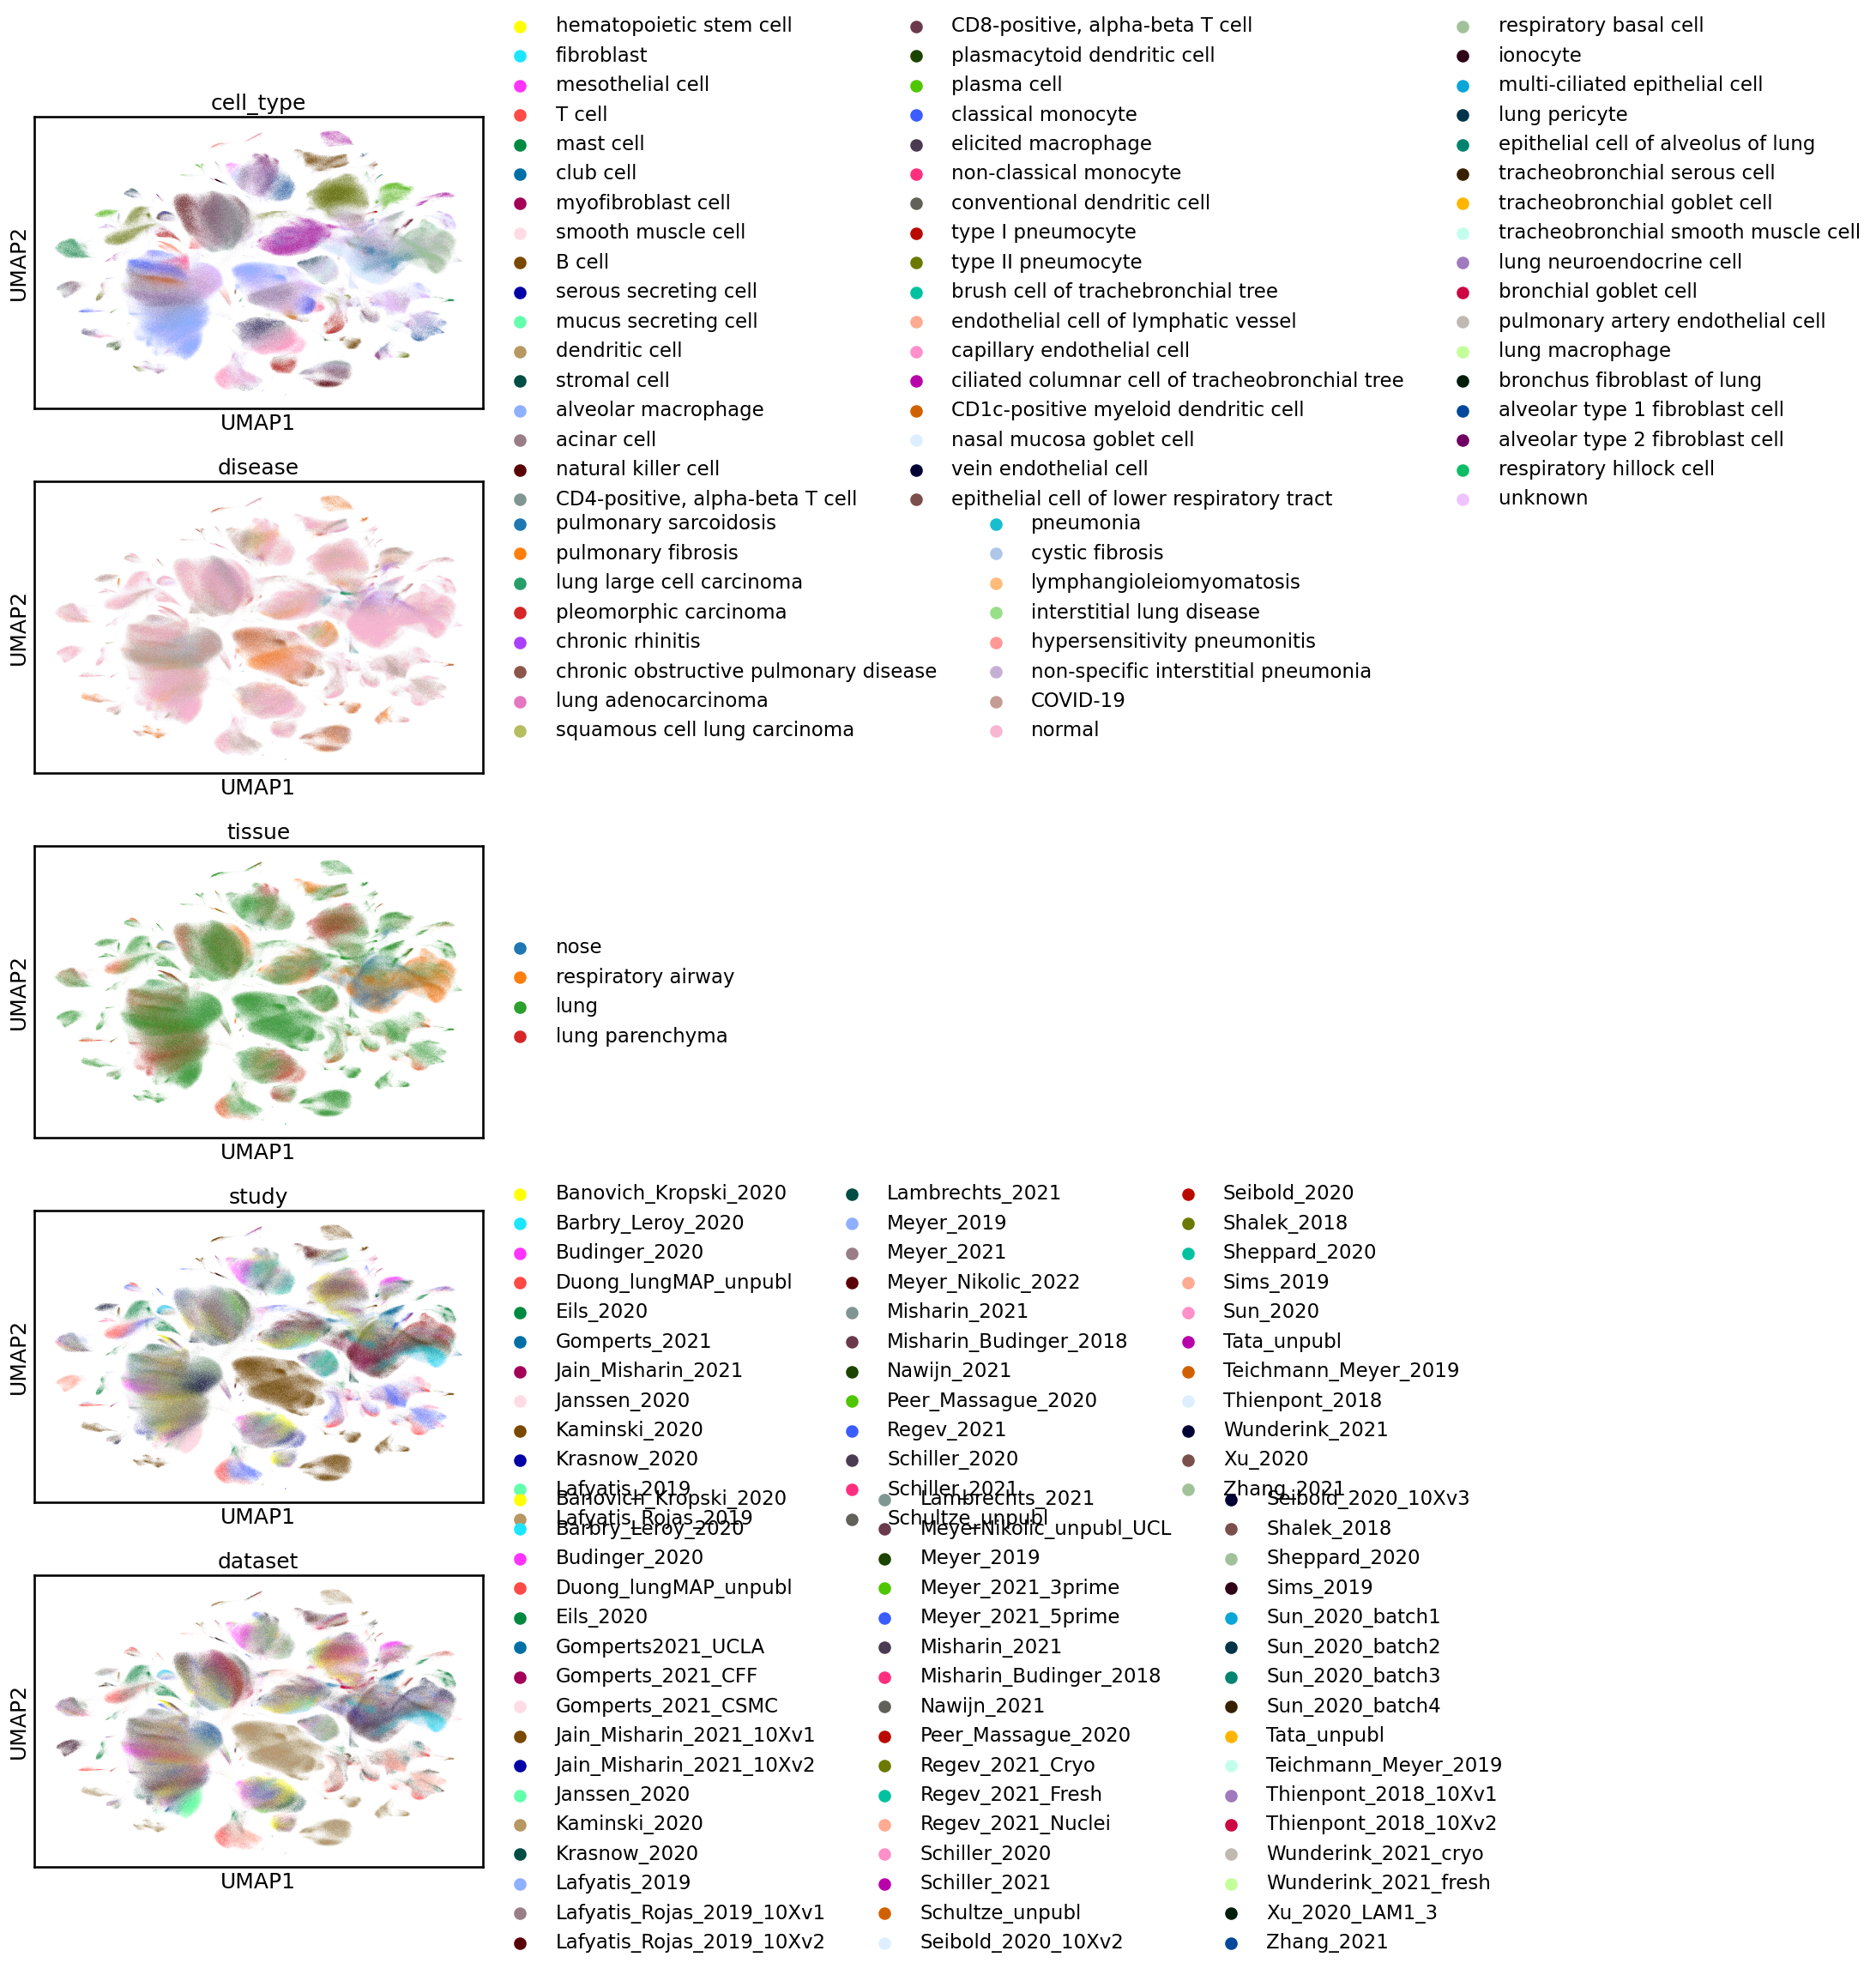

In [30]:
sc.pl.umap(hlca_adata_hvg, color=["cell_type","disease","tissue","study","dataset"],ncols=1)

## run PCA

In [6]:
hvg_adata = sc.read_h5ad("/data/rna_rep_learning/hlca_sikkema2023/hlca_HVGonly_w_scGPT_embeds.h5ad")
hvg_adata

AnnData object with n_obs × n_vars = 2282447 × 3494
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', '

In [7]:
hvg_adata.X.min()

0.0

In [ ]:
print("scale data...")
sc.pp.scale(hvg_adata, max_value=10)

print("compute PCA...")
sc.tl.pca(hvg_adata, svd_solver='arpack')

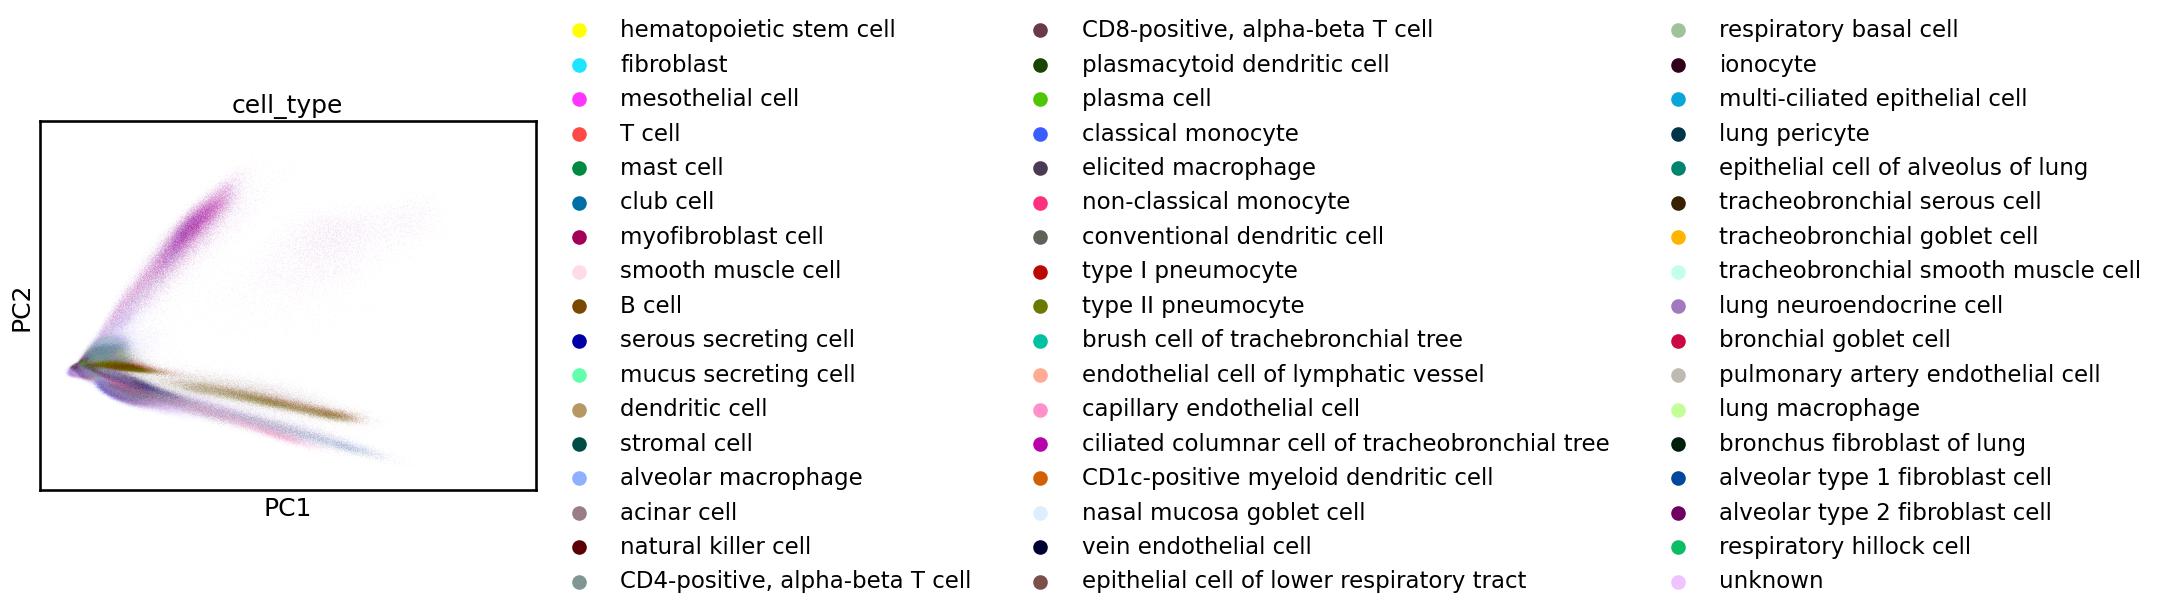

In [9]:
sc.pl.pca(hvg_adata, color='cell_type')

In [ ]:
# havent run this yet, kernel died

sc.pp.neighbors(hvg_adata, n_neighbors=10, n_pcs=20)

sc.tl.umap(hvg_adata)

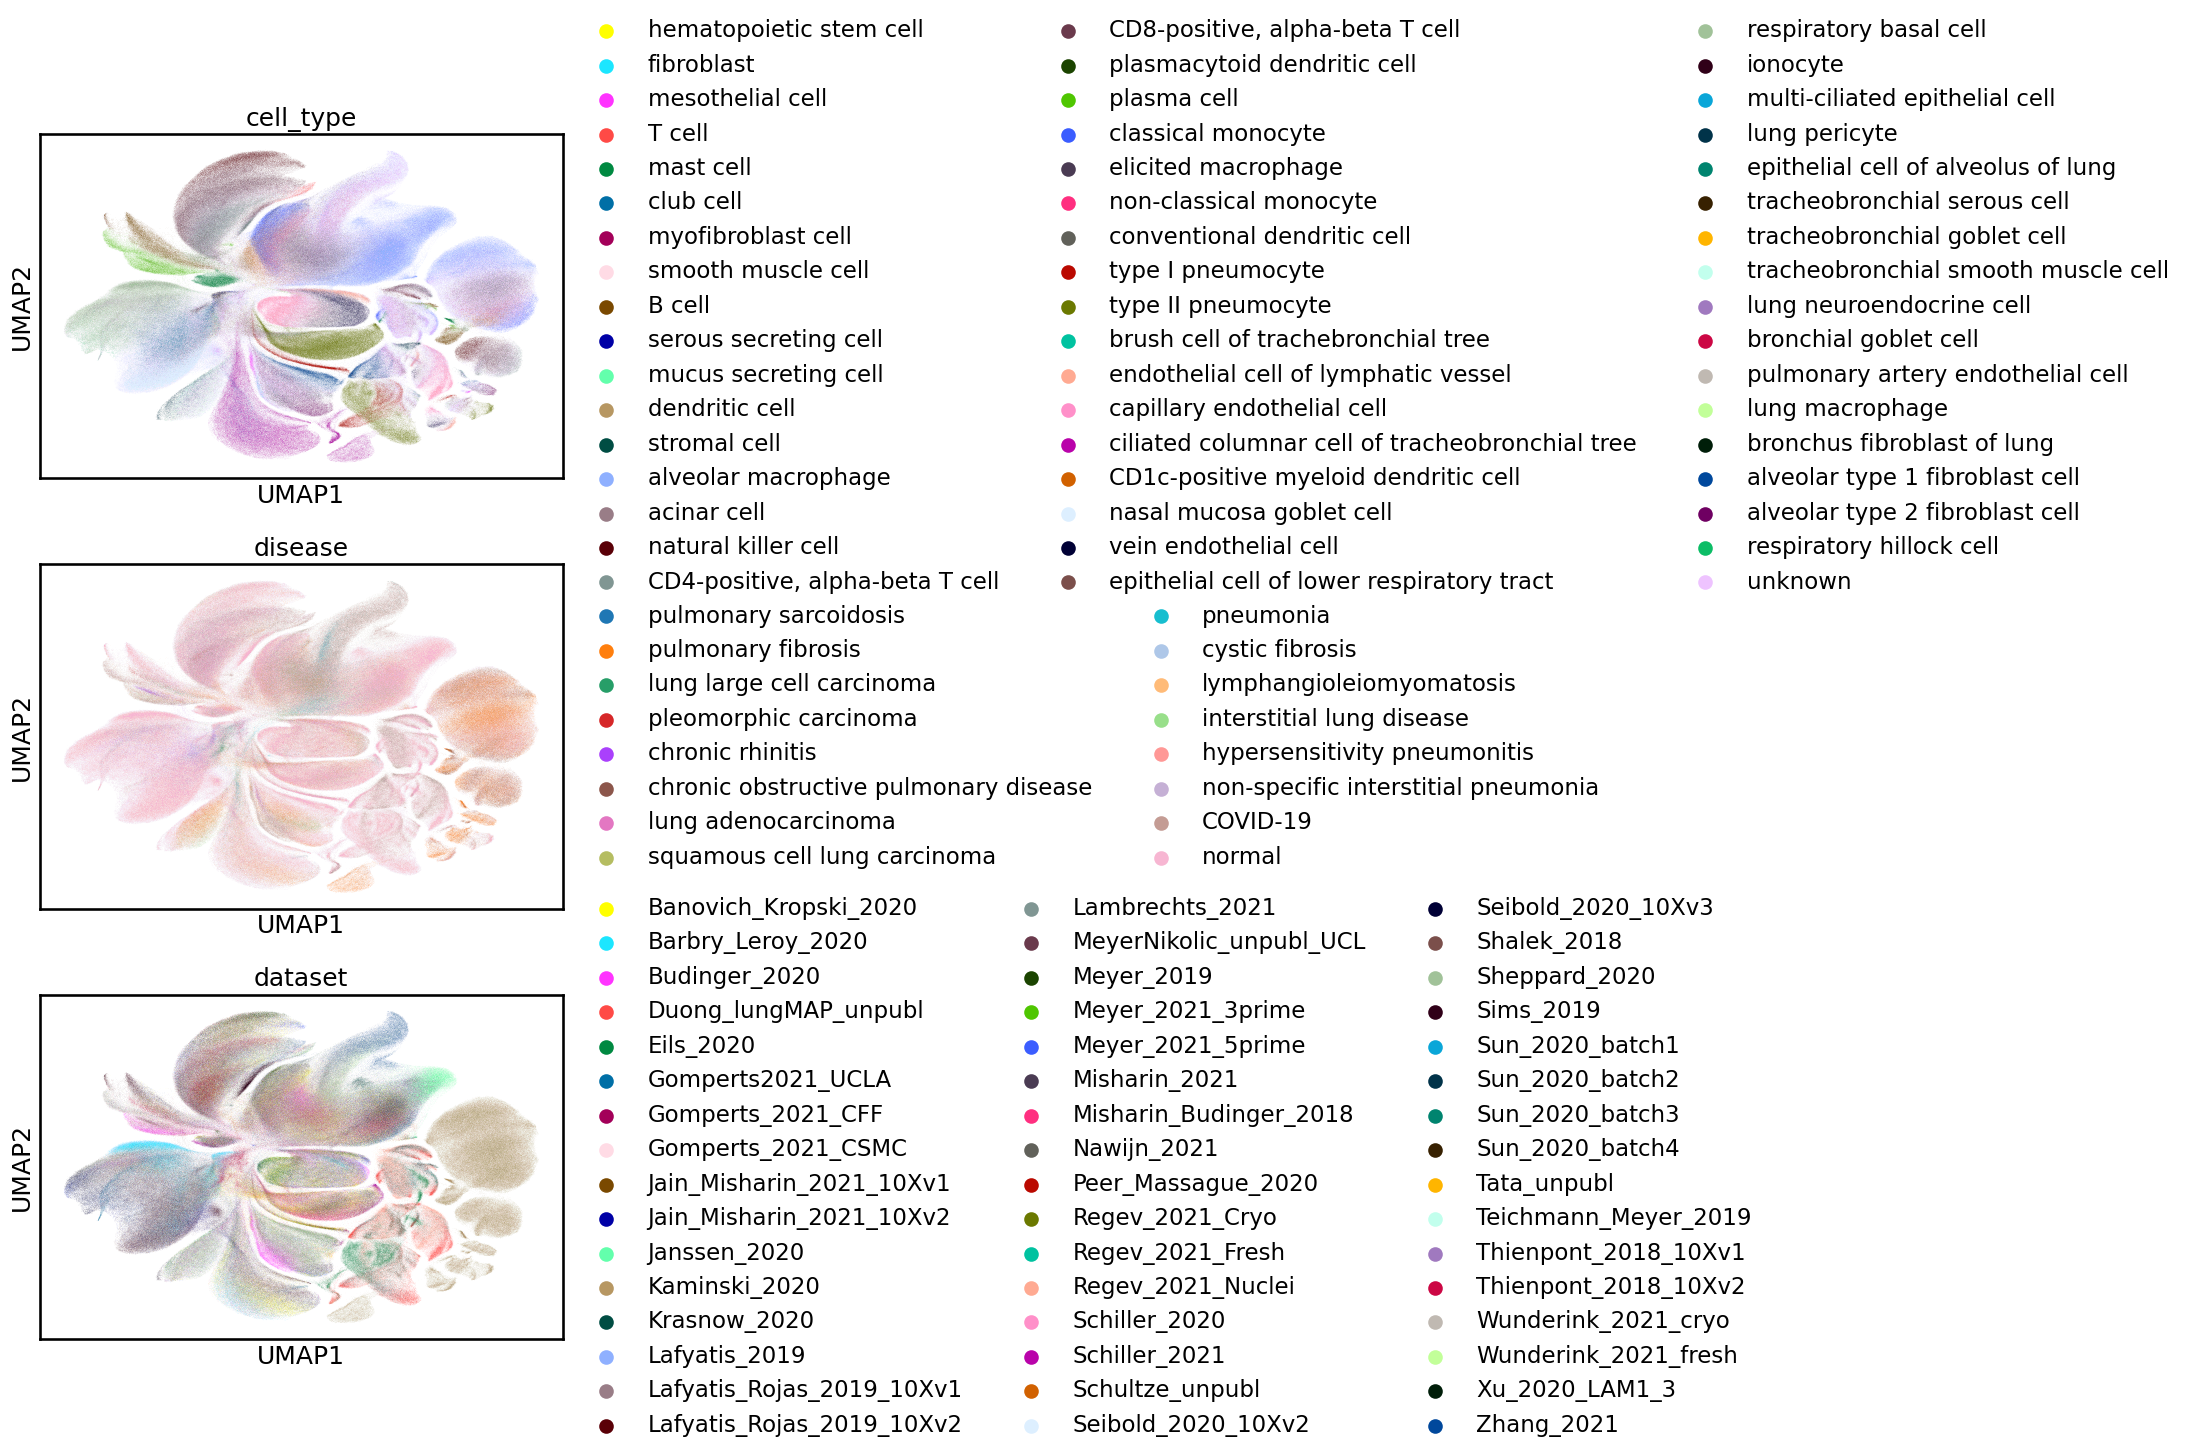

In [13]:
sc.pl.umap(hvg_adata, color=['cell_type', 'disease', 'dataset'], ncols=1)

In [12]:
#save to disk 
print("writing HVG subsetted, pre-processed (pca, umap) anndata object to disk...")
hvg_adata.write_h5ad("/data/rna_rep_learning/hlca_sikkema2023/hlca_HVGonly_w_scGPT_embeds.h5ad", compression="gzip")   

writing HVG subsetted, pre-processed (pca, umap) anndata object to disk...


In [14]:
hvg_adata

AnnData object with n_obs × n_vars = 2282447 × 3494
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', '

In [16]:
hvg_adata.obsm['X_pca'].shape

(2282447, 50)